In [2]:
#%pip install hyperspectral_gta_data

In [3]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# Part 1: Open the image and load the data as a numpy array.

In [4]:
# To download and use the Washington DC image:
#hsi_data.download('WashingtonDC')
fname = 'spectral_images/WashingtonDC_Ref_156bands/WashingtonDC_Ref_156bands'

# To download and use the polymers image:
# hsi_data.download('MicroscenePolymers')
# fname = 'Book Modules\spectral_images\Microscene_Polymers\reflectance_image_polymers

In [5]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
imArr = im.load()
print(f'Shape of ImArr = {imArr.shape}')

# To work with the data, we usually reshape the data from an image (# rows, # cols, # bands)
# into a standard (# observations, # features) array as (# pixels, # bands)
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (1280, 307, 156)
Shape of imList = (392960, 156)


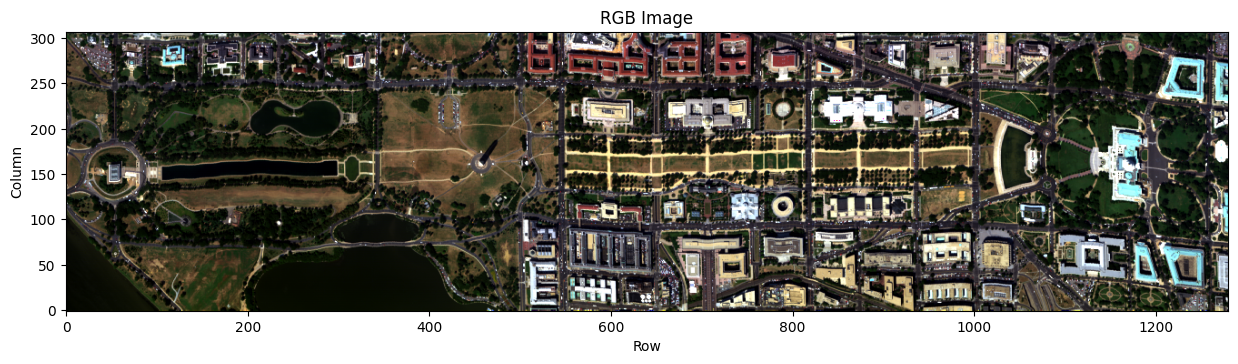

In [6]:
sm2.display_RGB(imArr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

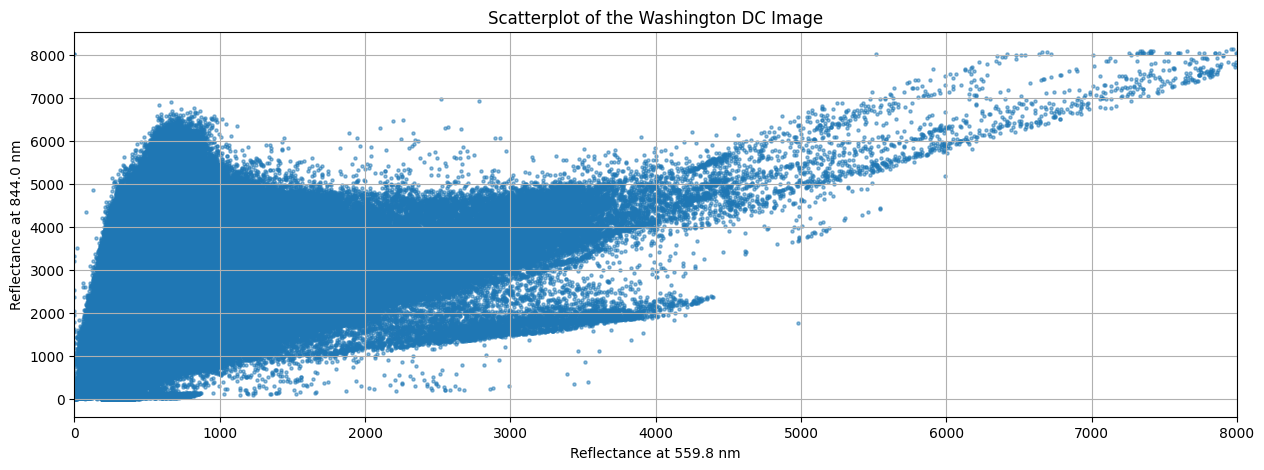

In [7]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(15,5))
plt.scatter(imList[:,i1], imList[:,i2], s=5, alpha=0.5);
plt.xlim(0,8000)
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Clustering using K-Means

Documentation on K Means clustering using sklearn in Python: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

A discussion of 11 clustering algorithms with Python implementations is provided in: https://scikit-learn.org/stable/modules/clustering.html

In [8]:
k = 4

# Step 0:
nRows, nCols, nBands = imArr.shape
nPix = nRows*nCols
class_index = np.random.randint(low=0, high=k, size=nPix)

Zero Mean and Unit Variance Normalization

Mean Centering: The first step of Zero Mean normalization involves subtracting the mean value of each feature from all data points. This centers the data around zero, meaning that the new mean of the feature becomes zero.\
Scaling to Unit Variance: The second step involves dividing each centered feature by its standard deviation. This scales the data so that the variance of each feature becomes one, hence the term “Unit Variance.”

https://www.geeksforgeeks.org/what-is-zero-mean-and-unit-variance-normalization/

Variance: average of the squared differences between each reflectance value and the mean (of a pixel/spectrum)

In [10]:
# Create an array of normalized (subtract mean, divide by standard deviation) spectra (each pixel is a spectrum of bands)
imListNormed = copy.copy(imList)
imListNormed.shape
imList_mu = np.mean(imList, axis=1) # for each pixel/spectrum, get the mean reflectance value across all bands (collapsing the bands/columns)
print(imList_mu.shape) # there's one mean value for each pixel

for j in range(nBands):
    imListNormed[:,j] = imListNormed[:,j] - imList_mu # get the difference between each pixel's (spectrum's) jth band's reflectance and the mean reflectance of that pixel/spectra (as a whole)
imList_stdev = np.sqrt((1/nBands)*np.sum(imListNormed**2, axis=1)) # sum up the squares of each pixel's difference values (collapsing the cols/differences); now there is one value per pixel;
                                                                    # then divide by nBands to get variance (average of the squared differences between each reflectance value and the mean)
                                                                    # std is the square root of the variance; there's one value per pixel/spectrum
imList_stdev_np = np.std(imList, axis=1)
    
print(imListNormed.shape) # the reflectance value of each band of each pixel is mean centered but not fully normed yet;
    # still has each pixel's set of differences (the differences between each band's original reflectance value and the original mean); the data is centered around 0; the mean is zero
print(imList_stdev.shape) # there's one std value for each pixel/spectrum
print(imList_stdev[:5])
print(imList_stdev_np[:5])
print(np.mean(np.abs(imList_stdev-imList_stdev_np)))

(392960,)
(392960, 156)
(392960,)
[57.922493 55.830067 53.614983 54.871162 53.946438]
[57.922493 55.830063 53.614983 54.87116  53.946438]
5.128766e-06


In [14]:
for j in range(nBands):
    imListNormed[:,j] = imListNormed[:,j]/imList_stdev # divide the mean-centered reflectance value of each band (of each pixel/spectrum) by the std of that pixel/spectrum

# each pixel/spectrum is now mean-centered and scaled to have a variance of one (meaning the average of the squared differences between each reflectance value and the pixel/spectrum's mean is one)
# most of the data is within 2 standard deviations (for a normal distribution, about 95% of data is within 2 std)

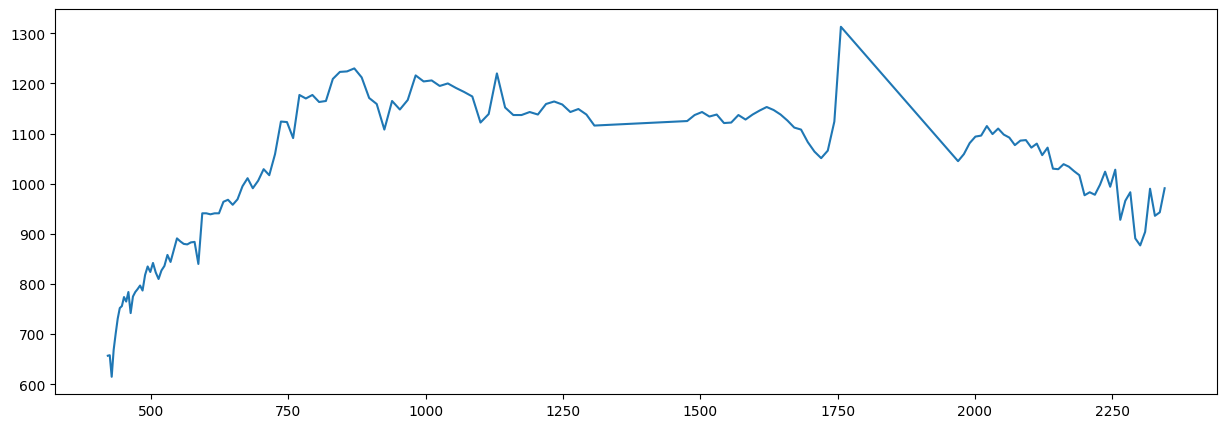

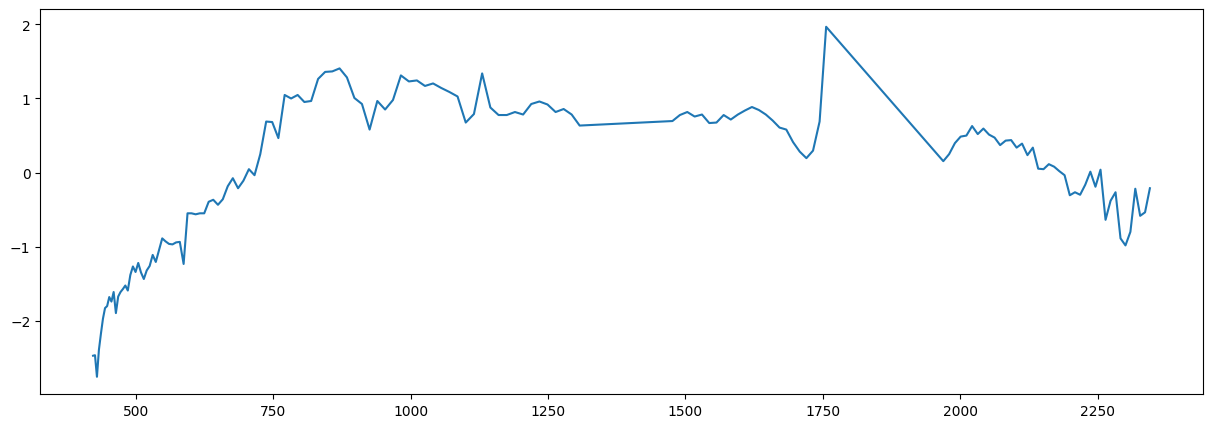

In [15]:
plt.figure(figsize=(15,5))
plt.plot(wl,imList[10000,:])
plt.figure(figsize=(15,5))
plt.plot(wl, imListNormed[10000,:])